In [1]:
# univariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from keras import Model, layers
from keras.models import load_model, model_from_json


Using TensorFlow backend.


In [2]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [3]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [4]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))


In [5]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)


In [6]:
# train the model
def build_and_train_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [7]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [8]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_and_train_model(train, n_input)
    model.save('models/Seq2Seq_UniVariate_Encoder-Decoder_LSTM_Model.h5')

    # architecture to JSON, weights to HDF5
    model.save_weights('models/Seq2Seq_UniVariate_Encoder-Decoder_LSTM_Model_Weights.h5')
    with open('models/Seq2Seq_UniVariate_Encoder-Decoder_LSTM_Model_architecture.json', 'w') as f:
            f.write(model.to_json())
            
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [9]:
def load_pretrained_model(train, test, n_input):
    # architecture and weights from HDF5
    model = load_model('models/Seq2Seq_UniVariate_Encoder-Decoder_LSTM_Model.h5')

    # architecture from JSON, weights from HDF5
    with open('models/Seq2Seq_UniVariate_Encoder-Decoder_LSTM_Model_architecture.json') as f:
        model = model_from_json(f.read())
    model.load_weights('models/Seq2Seq_UniVariate_Encoder-Decoder_LSTM_Model_Weights.h5')
    
    
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
    

Epoch 1/20
1092/1092 [==============================] - 9s 9ms/step - loss: 707003.8610
Epoch 2/20
1092/1092 [==============================] - 6s 6ms/step - loss: 350467.5295: 0s - loss: 350662.14
Epoch 3/20
1092/1092 [==============================] - 6s 6ms/step - loss: 369164.7161
Epoch 4/20
1092/1092 [==============================] - 6s 6ms/step - loss: 350759.1988
Epoch 5/20
1092/1092 [==============================] - 6s 6ms/step - loss: 281483.3462
Epoch 6/20
1092/1092 [==============================] - 7s 7ms/step - loss: 264707.8528
Epoch 7/20
1092/1092 [==============================] - 8s 7ms/step - loss: 262677.2557
Epoch 8/20
1092/1092 [==============================] - 7s 6ms/step - loss: 252760.3981
Epoch 9/20
1092/1092 [==============================] - 7s 6ms/step - loss: 250089.0591
Epoch 10/20
1092/1092 [==============================] - 7s 6ms/step - loss: 248605.2392
Epoch 11/20
1092/1092 [==============================] - 7s 6ms/step - loss: 245657.3715
Epoch 12

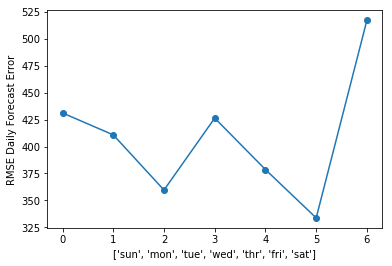

In [10]:
# load the new file
dataset = read_csv('smart meter dataset\household_power_consumption\household_power_consumption_Naive_Forecast_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

lstm: [412.052] 431.2, 410.9, 359.6, 426.5, 378.6, 333.7, 517.4


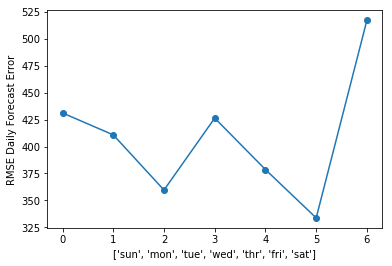

In [11]:
# load pretrained model and get scores
n_input = 14
score, scores = load_pretrained_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()